In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import webdataset as wds
import numpy as np
from itertools import islice
from collections import Counter
import glob
import os
import os.path
import pprint
pp = pprint.PrettyPrinter(indent=2, compact=True, depth=2).pprint
ppx = pprint.PrettyPrinter(indent=2, compact=True).pprint
import json

In [3]:
ds = wds.WebDataset("pubtabnet/pubtabnet-train-000000.tar").decode("rgb")

In [4]:
sample = next(islice(iter(ds), 100, 9999999))
print(sample.keys())

dict_keys(['__key__', 'json', 'png'])


In [5]:
pp(sample["json"])
pp(sample["json"]["html"]["cells"][0])

{ 'filename': 'PMC2590874_001_00.png',
  'html': {'cells': [...], 'structure': {...}},
  'imgid': 369099,
  'split': 'train'}
{ 'bbox': [0, 4, 30, 13],
  'tokens': ['<b>', 'V', 'a', 'r', 'i', 'a', 't', 'i', 'o', 'n', '</b>']}


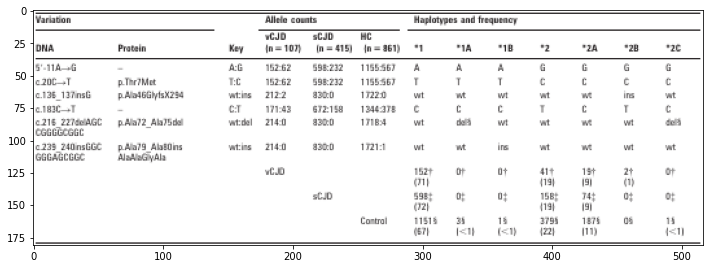

In [6]:
figsize(12, 8)
imshow(sample["png"])

In [7]:
for sample in ds:
    if "span" in json.dumps(sample["json"]).lower():
        break

In [8]:
ppx(sample["json"])

{ 'filename': 'PMC5651224_004_01.png',
  'html': { 'cells': [ { 'bbox': [7, 2, 74, 13],
                         'tokens': [ '<b>', 'P', 'r', 'e', 'd', 'i', 'c', 'a',
                                     't', 'i', 'o', 'n', ' ', 't', 'o', 'o',
                                     'l', '</b>']},
                       { 'bbox': [90, 2, 208, 13],
                         'tokens': [ '<b>', 'P', 'r', 'e', 'd', 'i', 'c', 't',
                                     'e', 'd', ' ', 'e', 'p', 'i', 't', 'o',
                                     'p', 'e', ' ', 's', 'e', 'q', 'u', 'e',
                                     'n', 'c', 'e', 's', '</b>']},
                       { 'bbox': [291, 2, 327, 13],
                         'tokens': [ '<b>', 'P', 'o', 's', 'i', 't', 'i', 'o',
                                     'n', '</b>']},
                       { 'bbox': [347, 2, 414, 13],
                         'tokens': [ '<b>', 'A', 'm', 'i', 'n', 'o', ' ', 'r',
                                     'e

In [9]:
ppx(sample["json"])

{ 'filename': 'PMC5651224_004_01.png',
  'html': { 'cells': [ { 'bbox': [7, 2, 74, 13],
                         'tokens': [ '<b>', 'P', 'r', 'e', 'd', 'i', 'c', 'a',
                                     't', 'i', 'o', 'n', ' ', 't', 'o', 'o',
                                     'l', '</b>']},
                       { 'bbox': [90, 2, 208, 13],
                         'tokens': [ '<b>', 'P', 'r', 'e', 'd', 'i', 'c', 't',
                                     'e', 'd', ' ', 'e', 'p', 'i', 't', 'o',
                                     'p', 'e', ' ', 's', 'e', 'q', 'u', 'e',
                                     'n', 'c', 'e', 's', '</b>']},
                       { 'bbox': [291, 2, 327, 13],
                         'tokens': [ '<b>', 'P', 'o', 's', 'i', 't', 'i', 'o',
                                     'n', '</b>']},
                       { 'bbox': [347, 2, 414, 13],
                         'tokens': [ '<b>', 'A', 'm', 'i', 'n', 'o', ' ', 'r',
                                     'e

In [10]:
src = iter(ds)

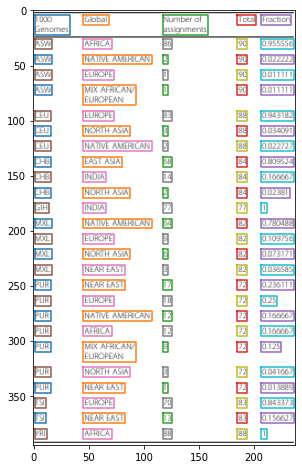

In [11]:
sample = next(src)
figsize(16, 8)
categories = ["black", "blue", "red", "green", "orange", "yellow", "cyan", "magenta"]
imshow(sample["png"])
for a in sample["json"]["html"]["cells"]:
    if "bbox" not in a:
        continue
    x, y, x1, y1 = a["bbox"]
    plot([x, x1, x1, x, x], [y, y, y1, y1, y])

In [12]:
_stop = False
def vertical_runs(im, margin=5):
    im0 = im.copy()
    im0[:margin, :] = 0
    im0[-margin:, :] = 0
    im0[:, :margin] = 0
    im0[:, -margin:] = 0
    if _stop:
        clf(); imshow(im0); raise ValueError("_stop")
    marked = im0 * arange(im.shape[0])[:, newaxis]
    lo = np.amin(where(marked==0, 9999, marked), 0)
    hi = np.amax(marked, 0)
    output = np.zeros_like(marked)
    for x, (i, j) in enumerate(zip(lo, hi)):
        output[i:j, x] = 1
    return np.maximum(output, im)
def text_outline(im):
    return np.maximum(vertical_runs(im), vertical_runs(im.T).T)
#imshow(text_outline(im))

In [13]:
import scipy.ndimage as ndi

def remove_rules(im, h=60, v=60):
    mask1 = ndi.maximum_filter(ndi.minimum_filter(im, (v, 0)), (v, 0))
    mask2 = ndi.maximum_filter(ndi.minimum_filter(im, (0, h)), (0, h))
    im = (im - mask1 - mask2).clip(0, 1)
    return im

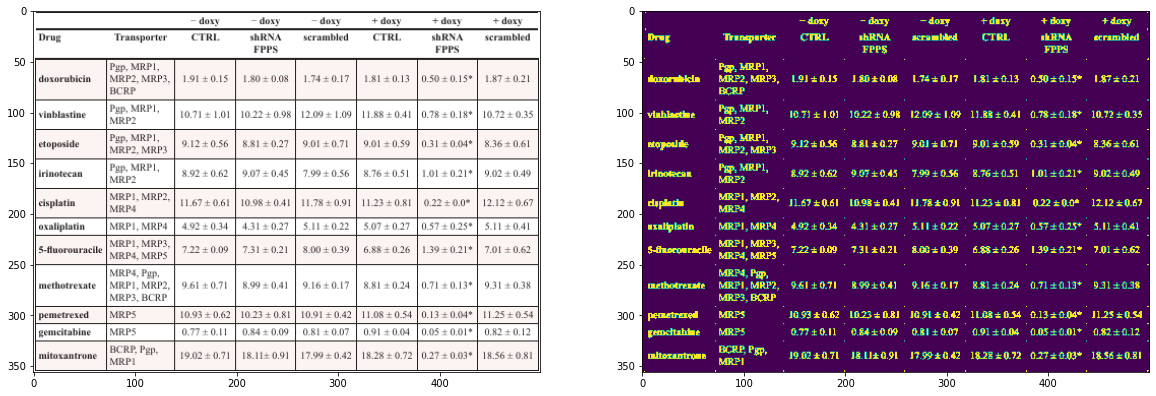

In [14]:
figsize(20, 10)
sample = next(src)
image = sample["png"]
binary = (np.mean(image, 2) < 0.9).astype(np.uint8)
binary = remove_rules(binary)
subplot(121); imshow(image)
subplot(122); imshow(binary)

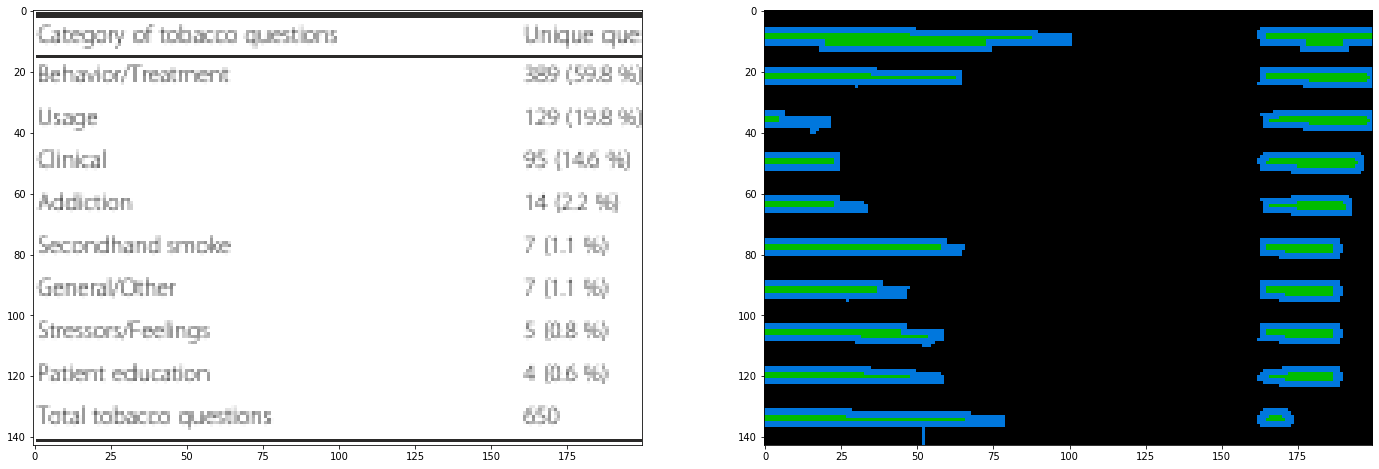

In [15]:
sample = next(src)

import scipy.ndimage as ndi

translate = np.array([0, 3, 3, 3, 1, 2], dtype=np.uint8)

def make_target(sample, threshold=0.9, text_r=(10, 10), r=(50, 50), dilate=0, margin=5, sigma=0.5):
    assert margin % 2 == 1
    image = sample["png"]
    binary = (np.mean(image, 2) < threshold).astype(np.uint8)
    # remove rules and boxes for mask computations (requires perfectly axis aligned images)
    binary = remove_rules(binary)
    ih, iw = image.shape[:2]
    target = np.zeros((ih, iw), dtype=np.uint8)
    #overlap = np.zeros((h, w))
    for a in sample["json"]["html"]["cells"]:
        value = 1
        if "bbox" not in a:
            continue
        x0, y0, x1, y1 = [int(x+0.5) for x in a["bbox"]]
        isolated = np.zeros((ih, iw), dtype=np.uint8)
        isolated[y0:y1, x0:x1] = binary[y0:y1, x0:x1]
        
        isolated = ndi.maximum_filter(isolated, text_r)
        isolated = ndi.minimum_filter(isolated, text_r)
        isolated = text_outline(isolated)
        
        if dilate > 0:
            isolated = ndi.maximum_filter(isolated, dilate)        

        target = np.maximum(1*isolated, target)
        isolated = ndi.minimum_filter(isolated, margin)
        target = np.maximum(2*isolated, target)

        assert np.amin(target) == 0
    assert np.amax(target) <= 4
    return target.astype(np.uint8)
 
figsize(24, 12)
#imshow(make_target(sample)[200:1200, 200:1200], vmin=0, vmax=4, cmap="nipy_spectral", interpolation="nearest")
subplot(121); imshow(sample["png"][:200,:200,...])
subplot(122); imshow(make_target(sample)[:200,:200], vmin=0, vmax=4, cmap="nipy_spectral", interpolation="nearest")

In [16]:
import re

def make_targets(shard, n=999999999):
    output = "pubtabnet-seg/" + os.path.basename(shard)
    output = re.sub(".tar$", "-mseg2.tar", output)
    print(shard, output)
    sink = wds.TarWriter(output+".temp")
    ds = wds.WebDataset(shard).decode("rgb")
    for sample in islice(ds, 0, n):
        global last_sample
        target = make_target(sample)
        sample["target.png"] = target
        last_sample = sample
        sink.write(sample)
    sink.close()
    if os.path.exists(output):
        os.unlink(output)
    os.rename(output+".temp", output)
    return output

In [17]:
shards = sorted(glob.glob("pubtabnet/pubtabnet-train-*.tar")) + sorted(glob.glob("pubtabnet/pubtabnet-val-*.tar"))
len(shards)

52

In [18]:
make_targets("pubtabnet/pubtabnet-train-000000.tar", n=5)
!rm pubtabnet-seg/pubtabnet-train-000000-mseg2.tar

pubtabnet/pubtabnet-train-000000.tar pubtabnet-seg/pubtabnet-train-000000-mseg2.tar


dtype('uint8')

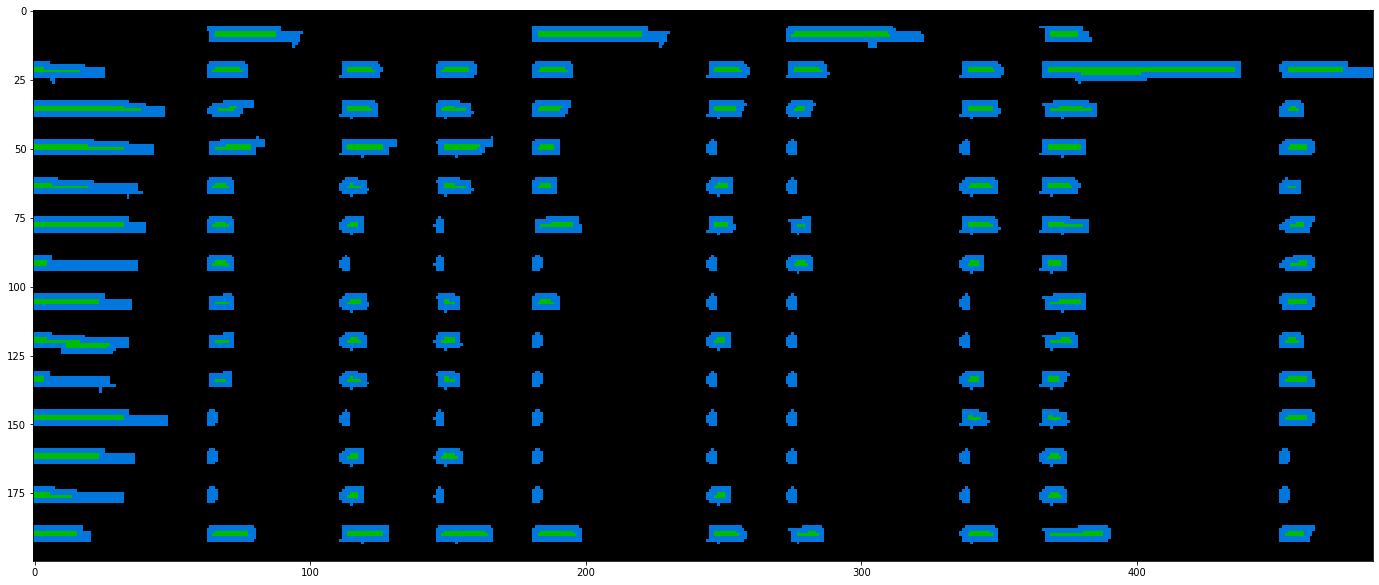

In [19]:
imshow(last_sample["target.png"][:200], vmin=0, vmax=4, cmap="nipy_spectral", interpolation="nearest")
last_sample["target.png"].dtype

In [20]:
from dask.distributed import Client, progress
client = Client(threads_per_worker=8, n_workers=1)
client

Client Scheduler: tcp://127.0.0.1:34153 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 1 Cores: 8 Memory: 33.58 GB


In [21]:
from dask.delayed import delayed
result = delayed([delayed(make_targets)(shard) for shard in shards])
result.compute()

['pubtabnet-seg/pubtabnet-train-000000-mseg2.tar',
 'pubtabnet-seg/pubtabnet-train-000001-mseg2.tar',
 'pubtabnet-seg/pubtabnet-train-000002-mseg2.tar',
 'pubtabnet-seg/pubtabnet-train-000003-mseg2.tar',
 'pubtabnet-seg/pubtabnet-train-000004-mseg2.tar',
 'pubtabnet-seg/pubtabnet-train-000005-mseg2.tar',
 'pubtabnet-seg/pubtabnet-train-000006-mseg2.tar',
 'pubtabnet-seg/pubtabnet-train-000007-mseg2.tar',
 'pubtabnet-seg/pubtabnet-train-000008-mseg2.tar',
 'pubtabnet-seg/pubtabnet-train-000009-mseg2.tar',
 'pubtabnet-seg/pubtabnet-train-000010-mseg2.tar',
 'pubtabnet-seg/pubtabnet-train-000011-mseg2.tar',
 'pubtabnet-seg/pubtabnet-train-000012-mseg2.tar',
 'pubtabnet-seg/pubtabnet-train-000013-mseg2.tar',
 'pubtabnet-seg/pubtabnet-train-000014-mseg2.tar',
 'pubtabnet-seg/pubtabnet-train-000015-mseg2.tar',
 'pubtabnet-seg/pubtabnet-train-000016-mseg2.tar',
 'pubtabnet-seg/pubtabnet-train-000017-mseg2.tar',
 'pubtabnet-seg/pubtabnet-train-000018-mseg2.tar',
 'pubtabnet-seg/pubtabnet-train